# หาพารามิเตอร์ของ Prophet เพื่อใช้ทำนายปริมาณผลผลิตสินค้าเกษตร

https://facebook.github.io/prophet/docs/quick_start.html

In [1]:
import numpy as np
import pandas as pd

import os
import itertools
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from utils.preproc import read_yield, read_annually_data, read_month_data, add_regressor

py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

/home/yoyo/anaconda3/envs/oae/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## User Parameters

In [2]:
params = {
    'rice_in-season': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวนาปี.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวนาปี.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวเปลือกเจ้า.xlsx',
    },
    'rice_off-season': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวนาปรัง.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวนาปรัง.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวเปลือกเจ้า.xlsx',
    },
    
    'corn': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตข้าวโพดทั้งหมด.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ข้าวโพดเลี้ยงสัตว์.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาข้าวโพดเลี้ยงสัตว์.xlsx',
    },
    
    'palm': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตปาล์มน้ำมัน.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ปาล์มน้ำมัน.xlsx',
        'price_file' : 'OAE-process/OAE-ราคาปาล์มน้ำมัน.xlsx',
    },
    
    'cassava': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตมันสำปะหลัง.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่มันสำปะหลัง.xlsx',
        'price_file' : 'OAE-process/OAE-ราคามันสำปะหลังสดคละ.xlsx',
    },
    
    'rubber': {
        'yield_file' : 'OAE-process/OAE-ผลผลิตยางพารา.xlsx',
        'cost_file' : 'OAE-process/OAE-ต้นทุนรวมต่อไร่ยางพารา.xlsx',
        'price_file' : ['OAE-process/OAE-ราคาน้ำยางสดคละ.xlsx', 'OAE-process/OAE-ราคายางก้อน.xlsx', 'OAE-process/OAE-ราคายางแผ่นดิบชั้น3.xlsx'],
    }
}

ptype = 'rice_off-season'#'corn'#'rice_off-season'#'corn'#'rice_in-season'
param = params[ptype]
yield_file = param['yield_file']
cost_file = param['cost_file']
price_file = param['price_file']
# is_harvest_season = param['harvest']

In [3]:
df, df_group = read_yield(yield_file)

In [4]:
N = np.where((df_group.cumsum() / df_group.sum()) >= .8)[0][0]
N

20

In [5]:
f"Percentage of training data: {df_group[:N+1]['value'].sum() / df_group['value'].sum():.3f}"

'Percentage of training data: 0.804'

In [6]:
df_group[:N+1]

,value
area,
Suphan Buri,2570861
Phra Nakhon Si Ayutthaya,2106367
Phitsanulok,1983621
Nakhon Sawan,1956327
Phichit,1903310
Kamphaeng Phet,1653929
Sukhothai,1386476
Chiang Rai,1356065
Chachoengsao,1278932


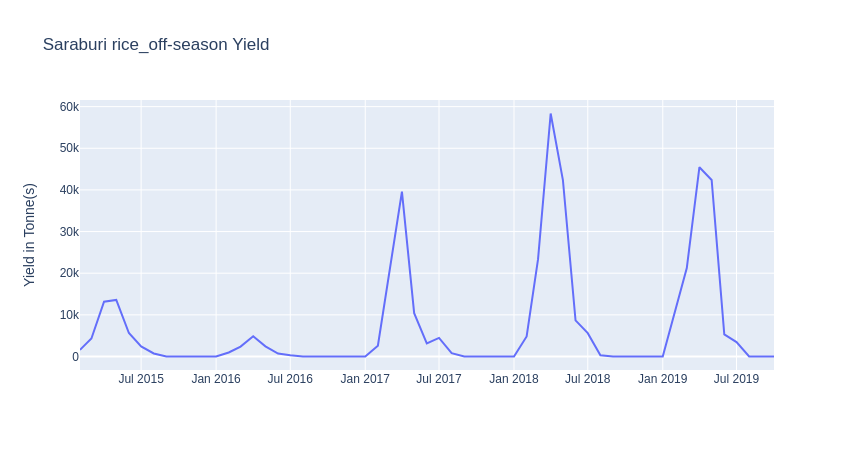

In [7]:
# area = df_group.iloc[N-1].name
area = df_group.iloc[N].name
_, _, df_area = read_yield(yield_file, area)

py.iplot({'data':go.Scatter(x=df_area['ds'], y=df_area['y'], name='y'),
         'layout':dict(title = area + " " + ptype + ' Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

Util functions

<AxesSubplot:title={'center':'price'}, xlabel='ds'>

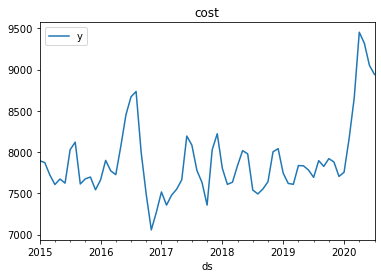

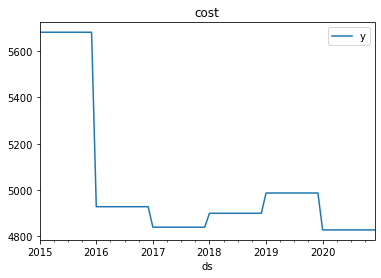

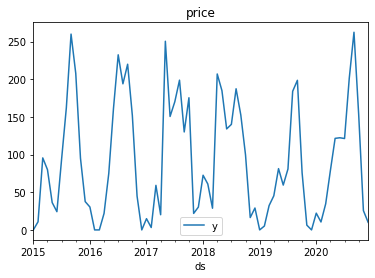

In [8]:
df_cost = read_annually_data(cost_file)

precipitation_file = 'OAE-process/OAE-ปริมาณน้ำฝน-ฝนตก.xlsx'
df_precipitation = read_month_data(precipitation_file, area)

if ptype == 'rubber':
    df_price1 = read_month_data(price_file[0])
    df_price2 = read_month_data(price_file[1])
    df_price3 = read_month_data(price_file[2])
    
    col_regressor = ['cost', 'precipitation', 'price_latex', 'price_cup', 'price_sheet']
    @add_regressor([df_cost, df_precipitation, df_price1, df_price2, df_price3], col_regressor)
    def add_features(df):
        return df
    
    df_price1.plot(title='price_latex')
    df_price2.plot(title='price_cup')
    df_price3.plot(title='price_sheet')
else:
    df_price = read_month_data(price_file)
    
    col_regressor = ['cost', 'precipitation', 'price']
    @add_regressor([df_cost, df_precipitation, df_price], col_regressor)
    def add_features(df):
        return df
    
    df_price.plot(title='cost')

df_cost.plot(title='cost')
df_precipitation.plot(title='price')

### Grid Search Parameters

In [9]:
param_grid = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1 ,2],
    'ps': [0, 1],
    'ds': [0, 1],
    'qs': [0, 1],
}

Generate all combinations of parameters

In [10]:
df_params = pd.DataFrame([dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())])
df_params

,p,d,q,ps,ds,qs
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,1,0
3,0,0,0,0,1,1
4,0,0,0,1,0,0
...,...,...,...,...,...,...
139,2,1,2,0,1,1
140,2,1,2,1,0,0
141,2,1,2,1,0,1
142,2,1,2,1,1,0


# Tuning using Grid Search

In [11]:
def all_provinces_predict(arg, areas):
#     print(arg)
    res = pd.DataFrame(columns = ['RMSE', 'MAE', 'AnnualErr'],
                       index = areas) 
    for province in areas:
        _, _, df_province = read_yield(yield_file, province)
        rmse, mae, aerr, _, _ = one_province_predict(df_province, arg)
        res.loc[province] = [rmse, mae, aerr] 
    return res

In [12]:
def one_province_predict(df_yield, arg):
    df_train, df_test = df_yield[12:], df_yield[:12]
    df_train = df_train.set_index('ds')
    df_train = df_train.resample('MS').asfreq()
    df_test = df_test.set_index('ds')
    df_test = df_test.resample('MS').asfreq() # frequency
    
    df_train = add_features(df_train).dropna()
    
    endog_col = df_train.columns[0]
    exog_col = df_train.columns[1:]
#     print('endog columns:', endog_col, '\nexog columns:', exog_col)
    
    endog = df_train.loc[:, endog_col]
    exog = df_train.loc[:, exog_col]
    
    df_train = df_train.sort_index() # sort
#     print(df_train)
    
    my_order = (arg['p'],arg['d'],arg['q'])
    my_seasonal_order = (arg['ps'], arg['ds'], arg['qs'], 12)
    # define model
    model = SARIMAX(endog=endog, exog=exog, order=my_order, seasonal_order=my_seasonal_order)

    try:
        model_fit = model.fit()
    except Exception as inst:
        print(type(inst))    # the exception instance
        print(inst)
        return None, None, None, None, None
#     print(model_fit.summary())
    
    df_test = df_test.sort_index()
    df_test = add_features(df_test).dropna()

    # exog_forecast = sm.add_constant(df_test.loc[:, ['cost', 'precipitation', 'rainday', 'price', 'on_season']])
    exog_forecast = df_test.loc[:, exog_col]
    
#     print(exog_forecast)
    
    #get the predictions and residuals
    predictions = model_fit.forecast(len(exog_forecast), exog=exog_forecast)
    # predictions = pd.Series(predictions, index=df_test.index)
    predictions.index = exog_forecast.index
    predictions.clip(lower=0, inplace=True)
    
    assert(np.all(predictions.index.to_numpy() == df_test.index.to_numpy()))
    residuals = df_test['y'] - predictions
    
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
#     mape = np.mean(abs(residuals / df_test['y']))
#     print('RMSE: %.2f' % rmse )
#     print('MAE: %.2f' % mae )
#     print('Mean Absolute Percent Error: %.2f' % mape)
    
    total_error = abs(1 - (np.sum(predictions) / np.sum(df_test['y']))) * 100
#     print('Total Error: %.3f' % total_error)
#     print('Forecast:', np.sum(predictions))
#     print('Ground Truth:', np.sum(df_test['y']))

    return rmse, mae, total_error, model_fit, predictions

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   45
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                -278.519
Date:                             Fri, 29 Jan 2021   AIC                            569.038
Time:                                     13:46:35   BIC                            578.017
Sample:                                 02-01-2015   HQIC                           572.059
                                      - 10-01-2018                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
cost              0.8085      1.782      0.454      0.650      -2.684       4.301
precipitation     

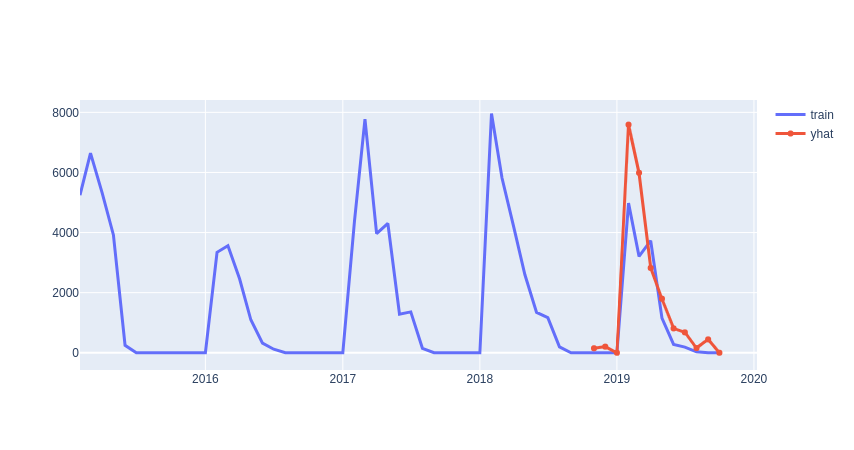

In [13]:
province = df_group.index[N]
_, _, df_province = read_yield(yield_file, 'Phetchabun')
rmse, mae, aerr, model, predictions = one_province_predict(df_province, {'p':1, 'd':0, 'q':1, 'ps':0, 'ds':1, 'qs':0})

print(model.summary())

py.iplot([
    go.Scatter(x=df_province['ds'], y=df_province['y'], name='train', line=dict(width=3)),
    go.Scatter(x=predictions.index, y=predictions, name='yhat', line=dict(width=3)),
])

In [14]:
# res = df_params.progress_apply(lambda x: all_provinces_predict(x, df_group.index[:N]), axis=1)
%time res = df_params.parallel_apply(lambda x: all_provinces_predict(x, df_group.index[:N+1]), axis=1)

CPU times: user 669 ms, sys: 127 ms, total: 796 ms
Wall time: 33min 45s


Get overall results

In [15]:
overview = df_params.merge(pd.concat([t.mean() for t in res], axis=1).T, 
                           left_index=True, 
                           right_index=True, 
                           validate="one_to_one")

In [16]:
overview_std = df_params.merge(pd.concat([t.std() for t in res], axis=1).T, 
                           left_index=True, 
                           right_index=True, 
                           validate="one_to_one")

In [17]:
minidx = overview['MAE'].idxmin()

Save result to Excel file

In [18]:
os.makedirs('./outputs/sarimax/', exist_ok = True)

with pd.ExcelWriter('./outputs/sarimax/' + ptype + '_output.xlsx') as writer:
    overview.iloc[minidx].to_excel(writer, sheet_name='best_param')
    overview.to_excel(writer, sheet_name='mean')
    overview_std.to_excel(writer, sheet_name='std')
    for i,t in enumerate(res):
        t.to_excel(writer, sheet_name=f'{i}')  

In [19]:
overview

,p,d,q,ps,ds,qs,RMSE,MAE,AnnualErr
0,0,0,0,0,0,0,39148.991504,27105.258622,23.459825
1,0,0,0,0,0,1,27551.540212,18399.954590,17.711159
2,0,0,0,0,1,0,10059.426649,5611.718247,9.020355
3,0,0,0,0,1,1,10522.092160,5783.887254,13.180468
4,0,0,0,1,0,0,11688.265011,6578.346848,12.203042
...,...,...,...,...,...,...,...,...,...
139,2,1,2,0,1,1,13629.815980,10825.857835,35.186635
140,2,1,2,1,0,0,17055.148799,11954.042165,12.991036
141,2,1,2,1,0,1,16691.222165,11584.682371,14.346394
142,2,1,2,1,1,0,14483.644157,11463.772815,40.135573


In [20]:
overview.iloc[minidx]

p               1.000000
d               0.000000
q               0.000000
ps              0.000000
ds              1.000000
qs              1.000000
RMSE         9956.395244
MAE          5296.567124
AnnualErr      12.024022
Name: 51, dtype: float64